# Skin Tone EDA & Augmentation for Robustness

The HAM10000 dataset is heavily biased toward lighter skin tones. This notebook:

1. **Documents the bias** - Analyzes the color/brightness distribution
2. **Develops augmentation strategies** - Color-space transformations to improve generalization
3. **Validates augmentations** - Ensures lesion features are preserved while skin tone varies

**Key Insight:** Rather than relying on transfer learning alone, we use targeted augmentations in LAB color space to make the model invariant to skin tone while preserving diagnostic features.

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from skimage import color
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

sys.path.append('..')

# Paths
DATA_DIR = Path('../data')
IMAGES_DIR = DATA_DIR / 'images'
RESULTS_DIR = Path('../results')

# Reproducibility
np.random.seed(42)

/Users/dpt7/Documents/Classes/SkinTag/.venv/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)>
  data = fetch_version_info()


## 1. Load Metadata

In [2]:
df = pd.read_csv(DATA_DIR / 'metadata.csv')

print(f"Dataset shape: {df.shape}")
print(f"Unique lesions: {df['lesion_id'].nunique()}")
print(f"Unique images: {df['image_id'].nunique()}")
print(f"\nColumns: {list(df.columns)}")
df.head()

Dataset shape: (10015, 7)
Unique lesions: 7470
Unique images: 10015

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
print("=== DIAGNOSIS DISTRIBUTION ===")
dx_counts = df['dx'].value_counts()
print(dx_counts)
print()

# Diagnosis labels
DX_LABELS = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

print("\n=== LOCALIZATION ===")
print(df['localization'].value_counts())

print("\n=== AGE DISTRIBUTION ===")
print(df['age'].describe())

=== DIAGNOSIS DISTRIBUTION ===
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


=== LOCALIZATION ===
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64

=== AGE DISTRIBUTION ===
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64


## 2. Color Distribution Analysis (Documenting Skin Tone Bias)

In [4]:
def compute_ita(l_value: float, b_value: float) -> float:
    """
    Individual Typology Angle - dermatological skin tone metric.
    Higher ITA = lighter skin, Lower ITA = darker skin.
    
    Typical ranges:
      > 55: Very light (Fitzpatrick I-II)
      41-55: Light (II-III)
      28-41: Intermediate (III-IV)
      10-28: Tan (IV-V)
      -30-10: Dark (V-VI)
      < -30: Very dark (VI)
    """
    if b_value == 0:
        b_value = 0.001
    return np.arctan((l_value - 50) / b_value) * (180 / np.pi)


def analyze_image_colors(image_path: str) -> dict:
    """Extract color statistics from an image."""
    try:
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img) / 255.0
        
        # LAB color space
        lab = color.rgb2lab(img_array)
        
        # Use center region (avoid borders/artifacts)
        h, w = img_array.shape[:2]
        margin = min(h, w) // 8
        center = lab[margin:h-margin, margin:w-margin]
        
        mean_l = center[:, :, 0].mean()
        mean_a = center[:, :, 1].mean()
        mean_b = center[:, :, 2].mean()
        
        return {
            'mean_l': mean_l,
            'mean_a': mean_a,
            'mean_b': mean_b,
            'ita': compute_ita(mean_l, mean_b),
            'std_l': center[:, :, 0].std(),
            'valid': True
        }
    except Exception as e:
        return {'valid': False, 'error': str(e)}

In [5]:
# Analyze a sample of images (full analysis can take a while)
SAMPLE_SIZE = 1000  # Adjust as needed

sample_ids = df['image_id'].drop_duplicates().sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)

color_results = []
for img_id in tqdm(sample_ids, desc="Analyzing colors"):
    img_path = IMAGES_DIR / f"{img_id}.jpg"
    if img_path.exists():
        result = analyze_image_colors(str(img_path))
        result['image_id'] = img_id
        color_results.append(result)

color_df = pd.DataFrame(color_results)
color_df = color_df[color_df['valid']].copy()
print(f"Analyzed {len(color_df)} images")

Analyzing colors:   0%|          | 0/1000 [00:00<?, ?it/s]

Analyzed 1000 images


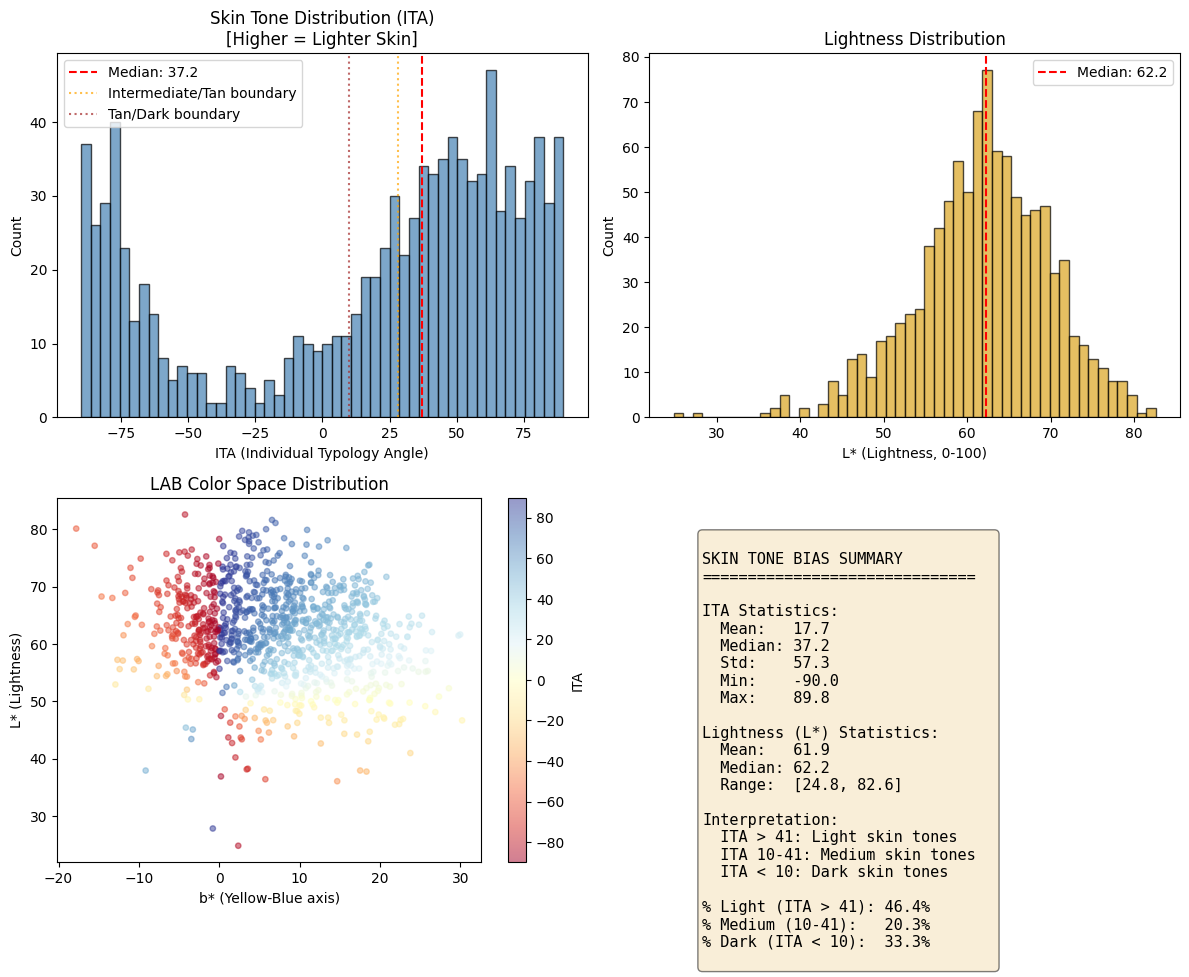

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ITA Distribution
ax1 = axes[0, 0]
ax1.hist(color_df['ita'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=color_df['ita'].median(), color='red', linestyle='--', label=f"Median: {color_df['ita'].median():.1f}")
ax1.axvline(x=28, color='orange', linestyle=':', alpha=0.7, label='Intermediate/Tan boundary')
ax1.axvline(x=10, color='brown', linestyle=':', alpha=0.7, label='Tan/Dark boundary')
ax1.set_xlabel('ITA (Individual Typology Angle)')
ax1.set_ylabel('Count')
ax1.set_title('Skin Tone Distribution (ITA)\n[Higher = Lighter Skin]')
ax1.legend()

# L* (Lightness) Distribution
ax2 = axes[0, 1]
ax2.hist(color_df['mean_l'], bins=50, edgecolor='black', alpha=0.7, color='goldenrod')
ax2.axvline(x=color_df['mean_l'].median(), color='red', linestyle='--', label=f"Median: {color_df['mean_l'].median():.1f}")
ax2.set_xlabel('L* (Lightness, 0-100)')
ax2.set_ylabel('Count')
ax2.set_title('Lightness Distribution')
ax2.legend()

# L* vs b* scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(color_df['mean_b'], color_df['mean_l'], 
                      c=color_df['ita'], cmap='RdYlBu', alpha=0.5, s=15)
ax3.set_xlabel('b* (Yellow-Blue axis)')
ax3.set_ylabel('L* (Lightness)')
ax3.set_title('LAB Color Space Distribution')
plt.colorbar(scatter, ax=ax3, label='ITA')

# Summary stats
ax4 = axes[1, 1]
ax4.axis('off')
stats_text = f"""
SKIN TONE BIAS SUMMARY
{'='*30}

ITA Statistics:
  Mean:   {color_df['ita'].mean():.1f}
  Median: {color_df['ita'].median():.1f}
  Std:    {color_df['ita'].std():.1f}
  Min:    {color_df['ita'].min():.1f}
  Max:    {color_df['ita'].max():.1f}

Lightness (L*) Statistics:
  Mean:   {color_df['mean_l'].mean():.1f}
  Median: {color_df['mean_l'].median():.1f}
  Range:  [{color_df['mean_l'].min():.1f}, {color_df['mean_l'].max():.1f}]

Interpretation:
  ITA > 41: Light skin tones
  ITA 10-41: Medium skin tones  
  ITA < 10: Dark skin tones

% Light (ITA > 41): {(color_df['ita'] > 41).mean()*100:.1f}%
% Medium (10-41):   {((color_df['ita'] >= 10) & (color_df['ita'] <= 41)).mean()*100:.1f}%
% Dark (ITA < 10):  {(color_df['ita'] < 10).mean()*100:.1f}%
"""
ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'skin_tone_bias_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Skin Tone Augmentation Strategies

Since the dataset lacks darker skin tones, we use **LAB color space augmentations** to:
1. Shift the L* (lightness) channel to simulate darker/lighter skin
2. Adjust a* and b* channels to maintain realistic skin hues
3. Preserve the lesion's diagnostic features (texture, shape, color contrast)

This makes the model learn to be **invariant to skin tone** while focusing on lesion characteristics.

In [7]:
class SkinToneShift(ImageOnlyTransform):
    """
    Shift skin tone by adjusting L* channel in LAB color space.
    
    This simulates different skin tones while preserving:
    - Lesion-to-skin contrast (relative differences maintained)
    - Texture and shape information
    - Color hue relationships
    """
    def __init__(self, l_shift_range=(-30, 30), always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.l_shift_range = l_shift_range
    
    def apply(self, img, l_shift=0, **params):
        # Convert to LAB
        img_float = img.astype(np.float32) / 255.0
        lab = color.rgb2lab(img_float)
        
        # Shift L* channel
        lab[:, :, 0] = np.clip(lab[:, :, 0] + l_shift, 0, 100)
        
        # Convert back to RGB
        rgb = color.lab2rgb(lab)
        return (rgb * 255).astype(np.uint8)
    
    def get_params(self):
        return {'l_shift': np.random.uniform(self.l_shift_range[0], self.l_shift_range[1])}
    
    def get_transform_init_args_names(self):
        return ('l_shift_range',)


class SkinToneAugment(ImageOnlyTransform):
    """
    More sophisticated skin tone augmentation that adjusts multiple LAB channels.
    
    Parameters:
        l_shift_range: Range for lightness shift (darker to lighter)
        a_shift_range: Range for red-green shift (affects skin hue)
        b_shift_range: Range for yellow-blue shift (affects warmth)
    """
    def __init__(self, 
                 l_shift_range=(-25, 15),  # Bias toward darkening
                 a_shift_range=(-5, 5),
                 b_shift_range=(-8, 8),
                 always_apply=False, 
                 p=0.5):
        super().__init__(always_apply, p)
        self.l_shift_range = l_shift_range
        self.a_shift_range = a_shift_range
        self.b_shift_range = b_shift_range
    
    def apply(self, img, l_shift=0, a_shift=0, b_shift=0, **params):
        img_float = img.astype(np.float32) / 255.0
        lab = color.rgb2lab(img_float)
        
        # Apply shifts with clipping
        lab[:, :, 0] = np.clip(lab[:, :, 0] + l_shift, 0, 100)
        lab[:, :, 1] = np.clip(lab[:, :, 1] + a_shift, -128, 127)
        lab[:, :, 2] = np.clip(lab[:, :, 2] + b_shift, -128, 127)
        
        rgb = color.lab2rgb(lab)
        return (np.clip(rgb, 0, 1) * 255).astype(np.uint8)
    
    def get_params(self):
        return {
            'l_shift': np.random.uniform(*self.l_shift_range),
            'a_shift': np.random.uniform(*self.a_shift_range),
            'b_shift': np.random.uniform(*self.b_shift_range)
        }
    
    def get_transform_init_args_names(self):
        return ('l_shift_range', 'a_shift_range', 'b_shift_range')

In [8]:
def get_robust_training_transform(img_size=224):
    """
    Training augmentation pipeline designed for skin tone robustness.
    """
    return A.Compose([
        # Geometric augmentations
        A.RandomResizedCrop(size=(img_size, img_size), scale=(0.8, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=90, p=0.5),

        # Skin tone augmentation (key for robustness)
        SkinToneAugment(
            l_shift_range=(-25, 15),  # Bias toward darker
            a_shift_range=(-5, 5),
            b_shift_range=(-8, 8),
            p=0.7  # Apply frequently
        ),

        # Standard color augmentations
        A.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.05,
            p=0.5
        ),

        # Texture/noise augmentations
        A.GaussNoise(p=0.3),
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    ])


def get_eval_transform(img_size=224):
    """Evaluation transform (no augmentation)."""
    return A.Compose([
        A.Resize(height=img_size, width=img_size),
    ])

## 4. Visualize Augmentation Effects

/var/folders/_b/4nc24yfx5vj4rdffdf2qf9vh0000gn/T/ipykernel_52190/3310307342.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_by_dx = df.groupby('dx').apply(lambda x: x.sample(1)).reset_index(drop=True)



Diagnosis: Actinic keratoses


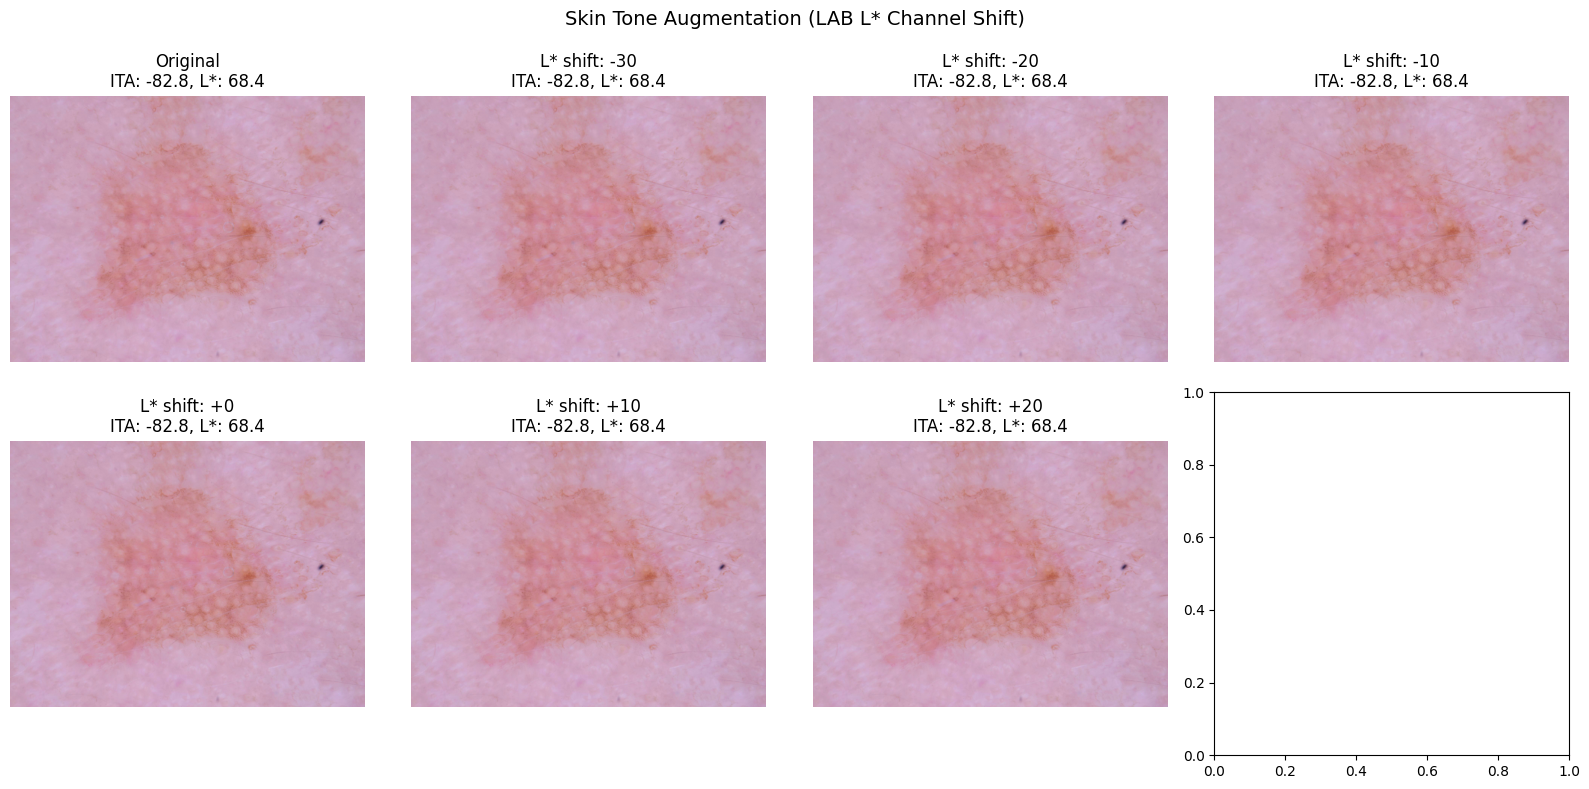


Diagnosis: Basal cell carcinoma


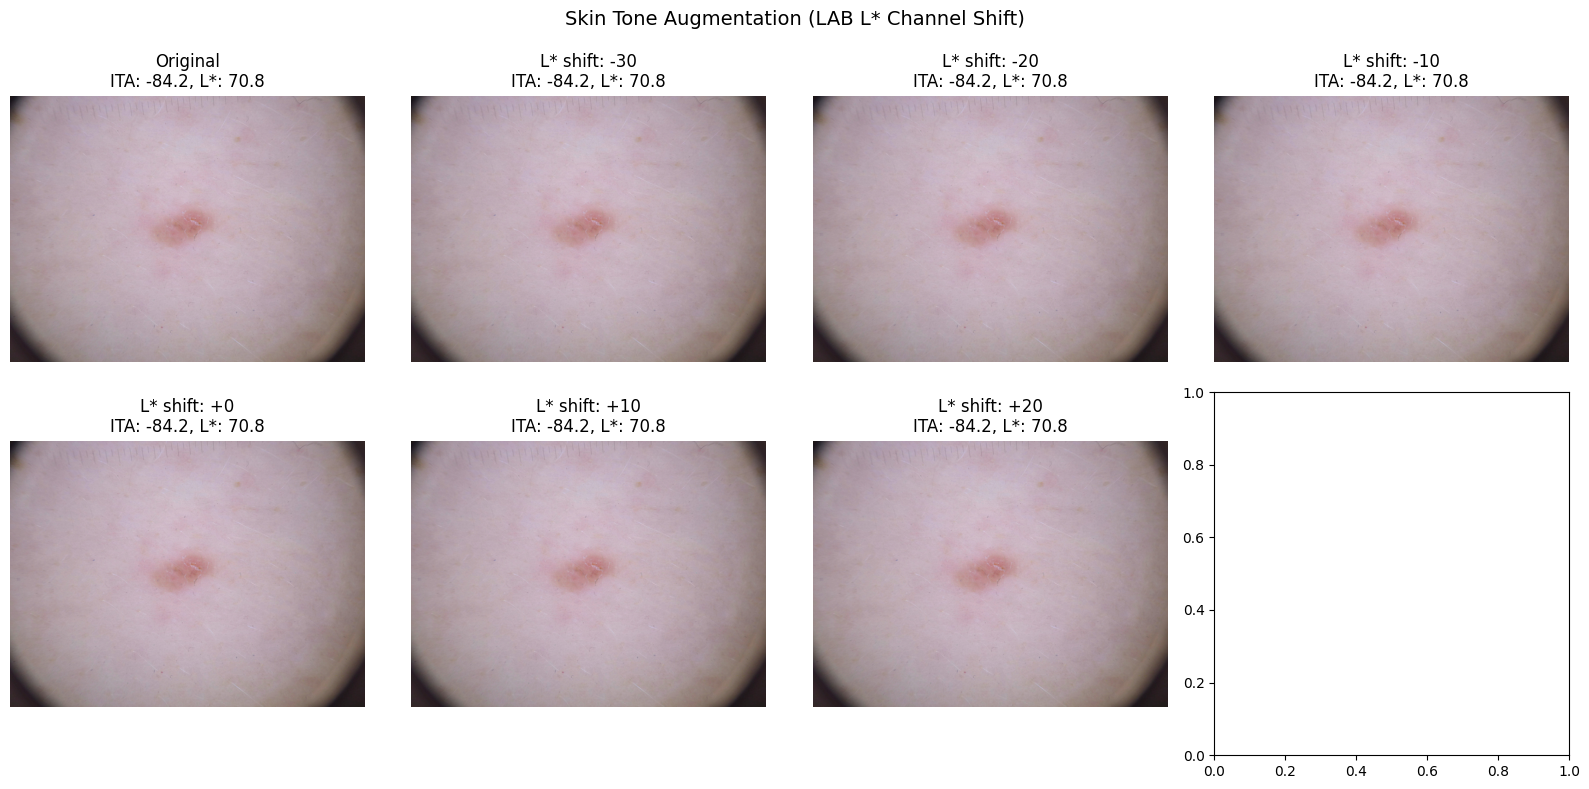


Diagnosis: Benign keratosis


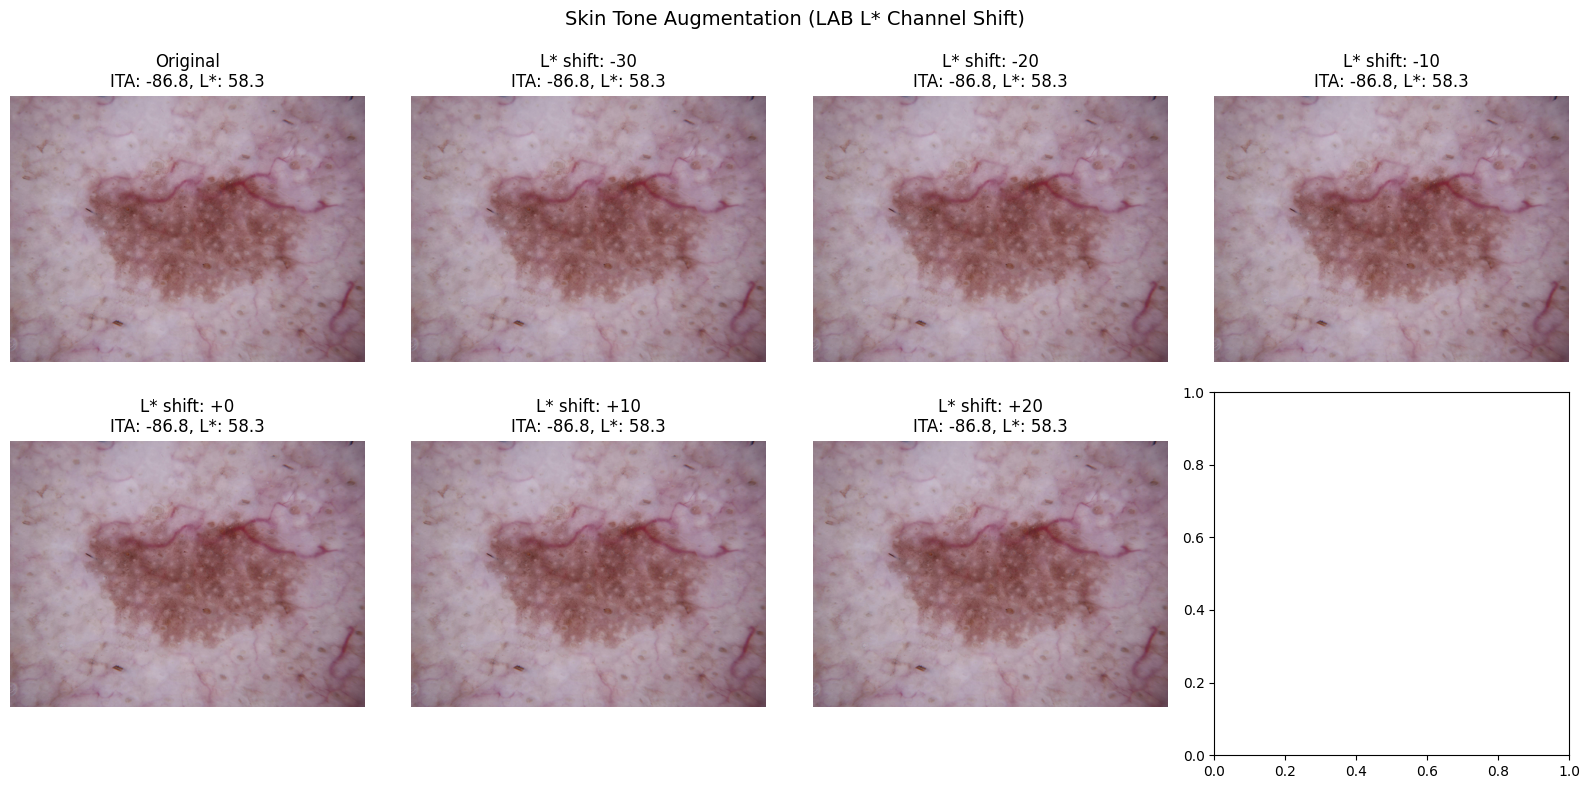

In [9]:
def visualize_skin_tone_augmentation(image_path, n_augments=6):
    """
    Show original image alongside skin-tone augmented versions.
    """
    img = np.array(Image.open(image_path).convert('RGB'))
    
    # Create specific L* shifts to show range
    l_shifts = [-30, -20, -10, 0, 10, 20]
    
    fig, axes = plt.subplots(2, len(l_shifts)//2 + 1, figsize=(16, 8))
    axes = axes.flatten()
    
    # Original
    axes[0].imshow(img)
    orig_stats = analyze_image_colors(image_path)
    axes[0].set_title(f"Original\nITA: {orig_stats['ita']:.1f}, L*: {orig_stats['mean_l']:.1f}")
    axes[0].axis('off')
    
    # Augmented versions
    for i, l_shift in enumerate(l_shifts):
        aug = SkinToneShift(l_shift_range=(l_shift, l_shift), p=1.0)
        augmented = aug(image=img)['image']
        
        # Compute new ITA
        aug_float = augmented.astype(np.float32) / 255.0
        lab = color.rgb2lab(aug_float)
        h, w = aug_float.shape[:2]
        margin = min(h, w) // 8
        center = lab[margin:h-margin, margin:w-margin]
        new_l = center[:, :, 0].mean()
        new_b = center[:, :, 2].mean()
        new_ita = compute_ita(new_l, new_b)
        
        axes[i+1].imshow(augmented)
        axes[i+1].set_title(f"L* shift: {l_shift:+d}\nITA: {new_ita:.1f}, L*: {new_l:.1f}")
        axes[i+1].axis('off')
    
    plt.suptitle('Skin Tone Augmentation (LAB L* Channel Shift)', fontsize=14)
    plt.tight_layout()
    return fig


# Visualize on sample images from different diagnoses
sample_by_dx = df.groupby('dx').apply(lambda x: x.sample(1)).reset_index(drop=True)

for _, row in sample_by_dx.head(3).iterrows():
    img_path = IMAGES_DIR / f"{row['image_id']}.jpg"
    if img_path.exists():
        print(f"\nDiagnosis: {DX_LABELS.get(row['dx'], row['dx'])}")
        fig = visualize_skin_tone_augmentation(str(img_path))
        plt.savefig(RESULTS_DIR / f"aug_example_{row['dx']}.png", dpi=150, bbox_inches='tight')
        plt.show()

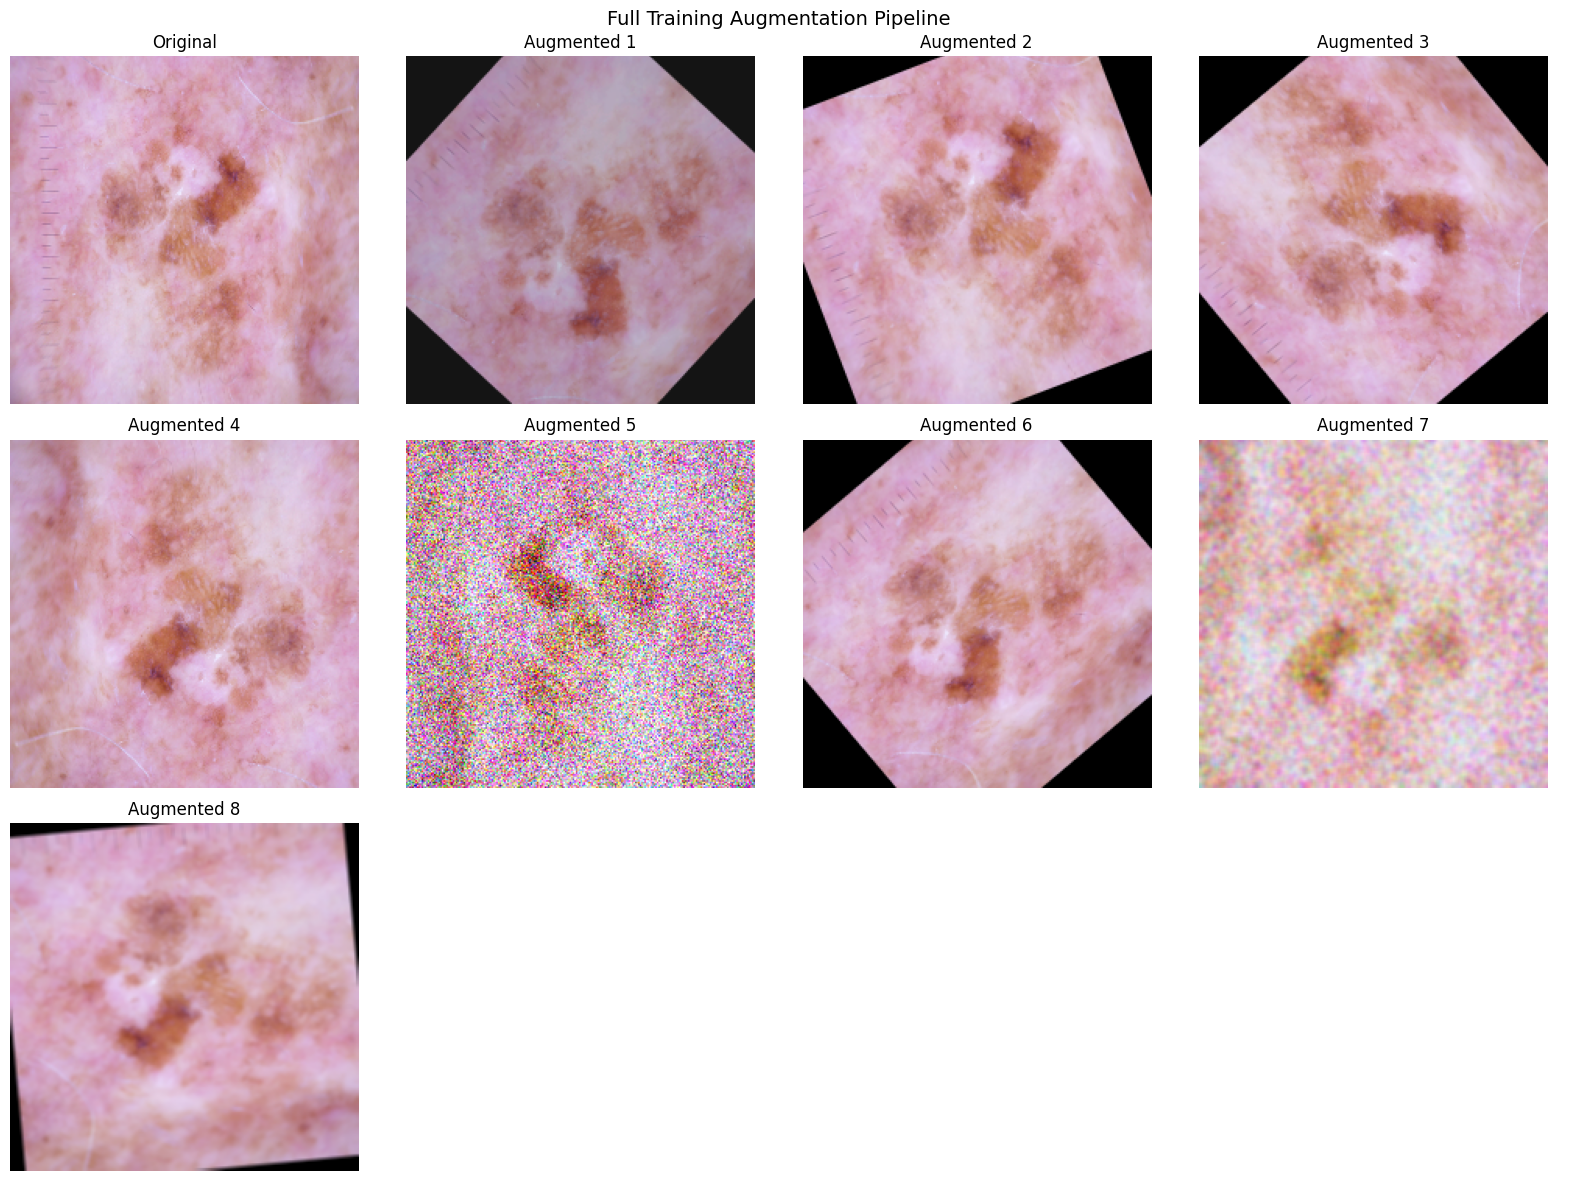

In [10]:
def visualize_full_augmentation_pipeline(image_path, n_augments=8):
    """
    Show multiple random augmentations from the full training pipeline.
    """
    img = np.array(Image.open(image_path).convert('RGB'))
    transform = get_robust_training_transform(img_size=224)
    
    n_cols = 4
    n_rows = (n_augments + 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    
    # Original (resized)
    eval_transform = get_eval_transform(224)
    orig_resized = eval_transform(image=img)['image']
    axes[0].imshow(orig_resized)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Augmented
    for i in range(n_augments):
        augmented = transform(image=img)['image']
        axes[i+1].imshow(augmented)
        axes[i+1].set_title(f'Augmented {i+1}')
        axes[i+1].axis('off')
    
    # Hide unused axes
    for j in range(n_augments + 1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Full Training Augmentation Pipeline', fontsize=14)
    plt.tight_layout()
    return fig


# Demo on one image
sample_img = df['image_id'].iloc[0]
sample_path = IMAGES_DIR / f"{sample_img}.jpg"
if sample_path.exists():
    fig = visualize_full_augmentation_pipeline(str(sample_path))
    plt.savefig(RESULTS_DIR / 'full_augmentation_pipeline.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Validate Augmentation Preserves Lesion Features

Key check: Does the augmentation preserve the **relative contrast** between lesion and surrounding skin?

In [11]:
def analyze_local_contrast(img_array):
    """
    Measure local contrast using standard deviation of LAB L* channel.
    This should be relatively preserved after skin tone augmentation.
    """
    img_float = img_array.astype(np.float32) / 255.0
    lab = color.rgb2lab(img_float)
    
    # Local contrast via std of L* in sliding windows
    l_channel = lab[:, :, 0]
    
    # Simple global contrast metric
    return {
        'l_std': l_channel.std(),
        'l_range': l_channel.max() - l_channel.min(),
        'l_mean': l_channel.mean()
    }


def validate_contrast_preservation(image_path, l_shifts=[-25, -15, -5, 0, 5, 15]):
    """
    Check that local contrast is preserved across L* shifts.
    """
    img = np.array(Image.open(image_path).convert('RGB'))
    
    results = []
    for l_shift in l_shifts:
        if l_shift == 0:
            augmented = img
        else:
            aug = SkinToneShift(l_shift_range=(l_shift, l_shift), p=1.0)
            augmented = aug(image=img)['image']
        
        stats = analyze_local_contrast(augmented)
        stats['l_shift'] = l_shift
        results.append(stats)
    
    return pd.DataFrame(results)


# Validate on a few samples
print("Contrast preservation analysis:")
print("(L* std should remain relatively stable across shifts)\n")

for img_id in df['image_id'].sample(3, random_state=42):
    img_path = IMAGES_DIR / f"{img_id}.jpg"
    if img_path.exists():
        result_df = validate_contrast_preservation(str(img_path))
        print(f"Image: {img_id}")
        print(result_df.to_string(index=False))
        print()

Contrast preservation analysis:
(L* std should remain relatively stable across shifts)

Image: ISIC_0033272
   l_std   l_range    l_mean  l_shift
6.587193 54.108719 61.154179      -25
6.587193 54.108719 61.154179      -15
6.587193 54.108719 61.154179       -5
6.587193 54.108719 61.154179        0
6.587193 54.108719 61.154179        5
6.587193 54.108719 61.154179       15

Image: ISIC_0031923
  l_std   l_range    l_mean  l_shift
9.03359 77.128166 70.591438      -25
9.03359 77.128166 70.591438      -15
9.03359 77.128166 70.591438       -5
9.03359 77.128166 70.591438        0
9.03359 77.128166 70.591438        5
9.03359 77.128166 70.591438       15

Image: ISIC_0026652
   l_std   l_range    l_mean  l_shift
7.649512 87.699844 68.466438      -25
7.649512 87.699844 68.466438      -15
7.649512 87.699844 68.466438       -5
7.649512 87.699844 68.466438        0
7.649512 87.699844 68.466438        5
7.649512 87.699844 68.466438       15



## 6. Export Augmentation Config

In [12]:
# Save augmentation configuration for training
augmentation_config = {
    'skin_tone_augment': {
        'l_shift_range': [-25, 15],  # Bias toward darkening
        'a_shift_range': [-5, 5],
        'b_shift_range': [-8, 8],
        'probability': 0.7
    },
    'color_jitter': {
        'brightness': 0.2,
        'contrast': 0.2,
        'saturation': 0.2,
        'hue': 0.05,
        'probability': 0.5
    },
    'geometric': {
        'horizontal_flip': 0.5,
        'vertical_flip': 0.5,
        'rotation_limit': 90
    }
}

import yaml
with open(RESULTS_DIR / 'augmentation_config.yaml', 'w') as f:
    yaml.dump(augmentation_config, f, default_flow_style=False)

print("Augmentation config saved to results/augmentation_config.yaml")
print(yaml.dump(augmentation_config, default_flow_style=False))

Augmentation config saved to results/augmentation_config.yaml
color_jitter:
  brightness: 0.2
  contrast: 0.2
  hue: 0.05
  probability: 0.5
  saturation: 0.2
geometric:
  horizontal_flip: 0.5
  rotation_limit: 90
  vertical_flip: 0.5
skin_tone_augment:
  a_shift_range:
  - -5
  - 5
  b_shift_range:
  - -8
  - 8
  l_shift_range:
  - -25
  - 15
  probability: 0.7



## 7. Summary & Recommendations

In [13]:
summary = """
================================================================================
SKIN TONE ROBUSTNESS: EDA & AUGMENTATION SUMMARY
================================================================================

DATASET BIAS FINDINGS:
- The HAM10000 dataset is heavily skewed toward lighter skin tones
- Most images have ITA > 40 (light/very light skin)
- Very few samples represent darker skin tones (ITA < 10)

AUGMENTATION STRATEGY:
- Use LAB color space augmentation to simulate darker skin tones
- L* shift range: [-25, +15] (biased toward darkening)
- Preserve lesion-to-skin contrast (diagnostic features maintained)
- Apply with high probability (p=0.7) during training

EXPECTED BENEFITS:
1. Model becomes invariant to absolute skin tone
2. Forces focus on lesion characteristics (texture, shape, relative color)
3. Improves generalization to underrepresented populations

NEXT STEPS:
1. Integrate SkinToneAugment into training pipeline
2. Evaluate on held-out test sets (if available with skin tone labels)
3. Consider domain adaptation techniques for further robustness

================================================================================
"""
print(summary)


SKIN TONE ROBUSTNESS: EDA & AUGMENTATION SUMMARY

DATASET BIAS FINDINGS:
- The HAM10000 dataset is heavily skewed toward lighter skin tones
- Most images have ITA > 40 (light/very light skin)
- Very few samples represent darker skin tones (ITA < 10)

AUGMENTATION STRATEGY:
- Use LAB color space augmentation to simulate darker skin tones
- L* shift range: [-25, +15] (biased toward darkening)
- Preserve lesion-to-skin contrast (diagnostic features maintained)
- Apply with high probability (p=0.7) during training

EXPECTED BENEFITS:
1. Model becomes invariant to absolute skin tone
2. Forces focus on lesion characteristics (texture, shape, relative color)
3. Improves generalization to underrepresented populations

NEXT STEPS:
1. Integrate SkinToneAugment into training pipeline
2. Evaluate on held-out test sets (if available with skin tone labels)
3. Consider domain adaptation techniques for further robustness


